# Bypass the RL, win money 🤑

This notebook is a pipeline for designing an efficient model for AWS Deepracer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

# Part 1 - Compute the optimal racing line

In [34]:
TRACK_NAME = 'Aragon'
NUMBER_STEPS_PER_SECOND = 15 

In [3]:
action_space = pd.DataFrame(columns = ['id', 'speed', 'steering'])
action_sequence = []
optimal_racing_line = pd.DataFrame(columns = ['x', 'y', 'speed', 'distance_from_last_point'])

### Load the appropriate Track

In [17]:
# Load the waypoints
waypoints = np.load("../tracks/" + TRACK_NAME + ".npy")

# Build the geometrical objects
center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

In [30]:
def print_shape(ax, shape):
    line = LineString(shape)
    x, y = line.xy                                                                
    ax.plot(x, y, '.', color='gray')   
    ax.plot(x, y, color='cyan', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2) 

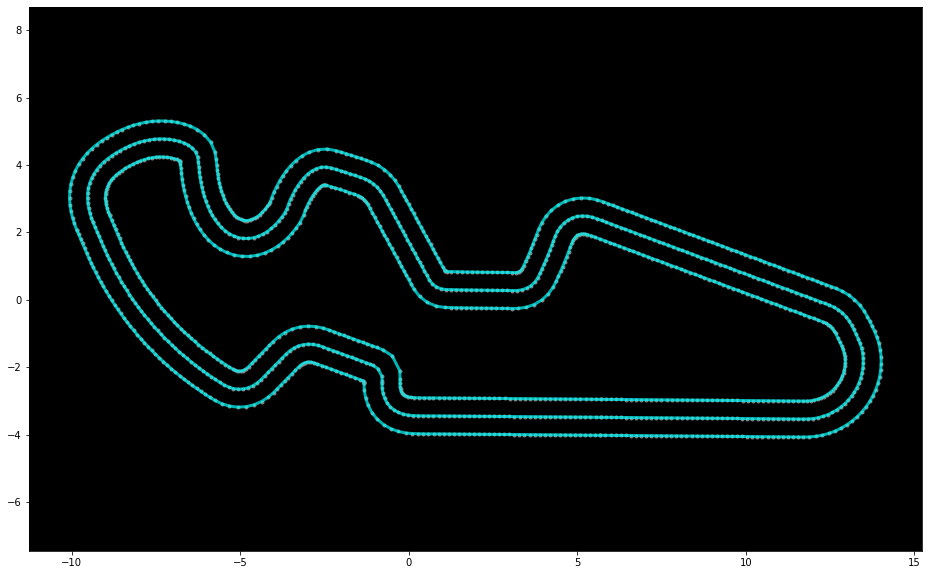

In [32]:
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_shape(ax, center_line)
print_shape(ax, inner_border)
print_shape(ax, outer_border)

# Part 2 - Compute the action space

# Part 3 - Compute the optimal racing line using only actions from the action space

### Utils

In [250]:
def compute_theta_from_coords(x0, x1, y0, y1):
    if x1 == x0:
        if y1 > y0:
            return np.pi / 2
        elif y1 < y0:
            return - np.pi / 2
        else:
            raise("Can't compute an angle when speed is null")
    elif x1 > x0:
        return np.arctan((y1-y0)/(x1-x0))
    else:
        return np.pi + np.arctan((y1-y0)/(x1-x0))
    

### Compute action sequence

In [265]:
# Mock action space, to work with it
action_space = pd.DataFrame({
    'id': [i for i in range(2001)], 
    'speed': [np.random.normal() + 2 for i in range(2001)],
    'steering': [np.random.normal() * 15 for i in range(2001)]
})

# Mock racing line, to work with it
optimal_racing_line = pd.DataFrame({
    'x': [np.cos(2*np.pi*i/20) for i in range(20)], 
    'y': [np.sin(2*np.pi*i/20) for i in range(20)],
    'speed': [3 for i in range(20)],
    'distance_from_last_point': [3/15 for i in range(20)]
})

In [266]:
# Easiest method : compute the 'closest action' (lowest  euclidian distance) for each step
def compute_action_sequence(action_space, optimal_racing_line):
    action_sequence = []
    for i in range(len(optimal_racing_line) - 2): # There is a minus 2 since we need at least 3 points to determine a steering angle
        # Compute geometrical data 
        (x0, x1, x2) = (optimal_racing_line['x'][i+k] for k in range(3)) 
        (y0, y1, y2) = (optimal_racing_line['y'][i+k] for k in range(3))
        angle_1 = compute_theta_from_coords(x0, x1, y0, y1)
        angle_2 = compute_theta_from_coords(x1, x2, y1, y2)
        rad_steering = angle_2 - angle_1 # CAREFUL : those are radiants
        speed = optimal_racing_line['speed'][i+1]
        
        # The optimal action
        order = np.array([speed, rad_steering])
        
        # Find the closest action from our action space (lowest euclidian distance)
        chosen_action_id = 0
        chosen_action_distance = 1000
        for j in range(len(action_space)):
            action = np.array([action_space['speed'][j], action_space['steering'][j]*2*np.pi/360])
            distance_to_optimal = np.linalg.norm(order - action)
            if distance_to_optimal < chosen_action_distance:
                chosen_action_id = action_space['id'][j]
                chosen_action_distance = distance_to_optimal
        action_sequence.append(chosen_action_id)
    
    return action_sequence

In [267]:
action_sequence = compute_action_sequence(action_space, optimal_racing_line)

### Plot the action sequence

In [268]:
def compute_real_racing_line(action_sequence, action_space, x0, y0, theta0):
    xs = []
    ys = []
    speeds = []
    distance_from_last_points = []
    cur_x = x0
    cur_y = y0
    cur_theta = theta0
    for action_id in action_sequence:
        speed = action_space.loc[action_space['id'] == action_id]['speed'].values[0]
        steering = action_space.loc[action_space['id'] == action_id]['steering'].values[0]
        cur_theta += steering * 2 * np.pi / 360
        cur_x += np.cos(cur_theta) * speed / NUMBER_STEPS_PER_SECOND
        cur_y += np.sin(cur_theta) * speed / NUMBER_STEPS_PER_SECOND
        xs.append(cur_x)
        ys.append(cur_y)
        speeds.append(speed)
        distance_from_last_points.append(speed / NUMBER_STEPS_PER_SECOND)
    real_racing_line = pd.DataFrame({
        'x': xs,
        'y': ys,
        'speed': speeds,
        'distance_from_last_point': distance_from_last_points
    })
    return real_racing_line

In [269]:
theta0 = compute_theta_from_coords(optimal_racing_line['x'][0], optimal_racing_line['x'][1], optimal_racing_line['y'][0], optimal_racing_line['y'][1])

real_racing_line = compute_real_racing_line(
    action_sequence, 
    action_space, 
    x0=optimal_racing_line['x'][0],
    y0=optimal_racing_line['y'][0],
    theta0=theta0
)

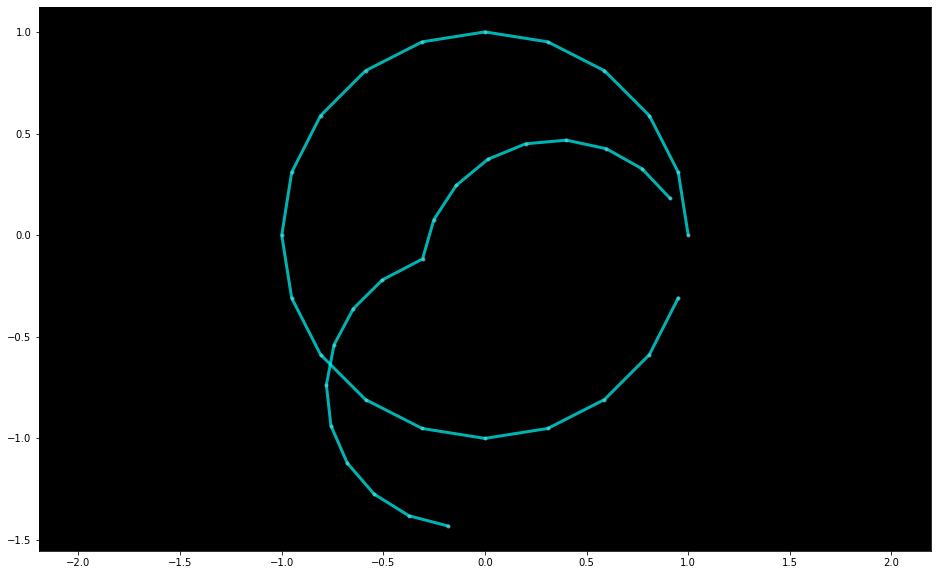

In [270]:
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_shape(ax, optimal_racing_line.drop(columns=['speed', 'distance_from_last_point']).values)
print_shape(ax, real_racing_line.drop(columns=['speed', 'distance_from_last_point']).values)

# Part 4 - Build the reward function